Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


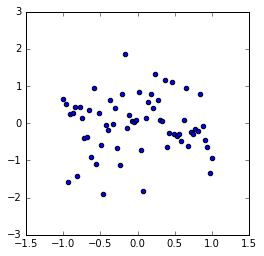

(64, 64)


In [4]:
# Play with tf basic functions
import matplotlib.pyplot as plt
%matplotlib inline
with tf.Session():
    t = tf.truncated_normal([64, 64])
    y = t.eval()
x = np.array([np.linspace(-1, 1, 64)])
plt.figure(figsize=(4,4))
plt.scatter(x, y[0])
plt.show()
print (y.shape)

In [5]:
# Play with tensor basics: dimesion, shape, reduce_xxx
with tf.Session():
    x = tf.constant([[1, 1, 1], [1, 1, 1]])
    y = tf.reduce_sum(x)
    print (x.get_shape())
    print (x.eval())
    print (y.eval())


(2, 3)
[[1 1 1]
 [1 1 1]]
6


---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

### This is regularization for 1-hidden-layer NN

In [41]:
import math
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE
hidden1_units = 1024
hidden2_units = 256
NUM_CLASSES = 10
batch_size = 200
TOTAL_STEPS = train_dataset.shape[0] // batch_size

def evaluate(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

# TODO: this inference only fits for 2 layer NN model, should know of away to do it
# more generically
def inference2(d, w1, b1, w2, b2):
    h1 = tf.nn.relu(tf.matmul(d, w1)+b1)
    logits = tf.nn.relu(tf.matmul(h1, w2)+b2)
    return tf.nn.softmax(logits)

def inference3(d, w1, b1, w2, b2, w3, b3):
    h1 = tf.nn.relu(tf.matmul(d, w1)+b1)
    h2 = tf.nn.relu(tf.matmul(h1, w2)+b2)
    logits = tf.nn.relu(tf.matmul(h2, w3)+b3)
    return tf.nn.softmax(logits)

graph = tf.Graph()
with graph.as_default():
    # Define the tensorflow in some default graph
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, IMAGE_PIXELS))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    w1 = tf.Variable(tf.truncated_normal([IMAGE_PIXELS, hidden1_units]), name='weights1')
    b1 = tf.Variable(tf.zeros([hidden1_units]), name='biases1')
    h1 = tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1)

    w2 = tf.Variable(tf.truncated_normal([hidden1_units, NUM_CLASSES]), name='weights2')
    b2 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases2')
    logits = tf.matmul(h1, w2) + b2
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    regularizers = (  tf.nn.l2_loss(w1) 
                    + tf.nn.l2_loss(b1) 
                    + tf.nn.l2_loss(w2) 
                    + tf.nn.l2_loss(b2))
    loss += 1e-5 * regularizers
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    predicted_train = inference2(tf_train_dataset, w1, b1, w2, b2)
    predicted_valid = inference2(valid_dataset, w1, b1, w2, b2)
    predicted_test = inference2(test_dataset, w1, b1, w2, b2)
    

with tf.Session(graph=graph) as sess:

    tf.initialize_all_variables().run()

    for step in xrange(TOTAL_STEPS):
        # Calculate the offset for the SGD training
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a batch slice
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare the feed dictionary
        data_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, pt1 = sess.run([optimizer, loss, predicted_train], feed_dict=data_dict)
        if step % 100 == 0:
            print ("Step %4d: %f %f %f loss %f"%(step+1, evaluate(pt1, batch_labels),
                                        evaluate(predicted_valid.eval(), valid_labels),
                                        evaluate(predicted_test.eval(), test_labels),
                                        l))
    print ("Step %4d: %f %f"%(step+1, evaluate(predicted_valid.eval(), valid_labels),
                                     evaluate(predicted_test.eval(), test_labels)))

Step    1: 8.000000 34.560000 37.680000 loss 493.913727
Step  101: 78.000000 80.360000 87.540000 loss 82.235283
Step  201: 83.000000 81.110000 88.430000 loss 39.831345
Step  301: 80.000000 81.340000 88.450000 loss 35.849998
Step  401: 86.000000 81.740000 89.320000 loss 28.311199
Step  501: 84.500000 83.450000 89.880000 loss 22.590942
Step  601: 82.000000 80.390000 86.380000 loss 31.901966
Step  701: 83.000000 83.550000 89.700000 loss 20.806921
Step  801: 83.500000 79.580000 86.130000 loss 25.482716
Step  901: 82.500000 83.640000 90.310000 loss 23.285282
Step 1000: 82.950000 90.220000


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

### This is testing dropout function in Tensorflow

In [24]:
with tf.Session():
    input1 = tf.constant([1.0, 1.0, 1.0, 1.0])
    output1 = tf.nn.dropout(input1, 0.5)
    result = output1.eval()
    print ("result: ", result)

result:  [ 2.  0.  0.  0.]


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [59]:
import math
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE
hidden1_units = 1024
hidden2_units = 256
hidden3_units = 128
NUM_CLASSES = 10
batch_size = 128
TOTAL_STEPS = train_dataset.shape[0] // batch_size

def evaluate(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

# TODO: this inference only fits for 2 layer NN model, should know of away to do it
# more generically
def inference2(d, w1, b1, w2, b2):
    h1 = tf.nn.relu(tf.matmul(d, w1)+b1)
    logits = tf.matmul(h1, w2)+b2
    return tf.nn.softmax(logits)

def inference3(d, w1, b1, w2, b2, w3, b3):
    h1 = tf.nn.relu(tf.matmul(d, w1)+b1)
    h2 = tf.nn.relu(tf.matmul(h1, w2)+b2)
    logits = tf.matmul(h2, w3)+b3
    return tf.nn.softmax(logits)

def inference4(d, w1, b1, w2, b2, w3, b3, w4, b4):
    hi1 = tf.nn.relu(tf.matmul(d, w1)+b1)
    hi2 = tf.nn.relu(tf.matmul(hi1, w2)+b2)
    hi3 = tf.nn.relu(tf.matmul(hi2, w3)+b3)
    logits = tf.matmul(hi3, w4)+b4
    return tf.nn.softmax(logits)

graph = tf.Graph()
with graph.as_default():
    # Define the tensorflow in some default graph
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, IMAGE_PIXELS))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Parameters
    global_step = tf.Variable(0)
    w1 = tf.Variable(tf.truncated_normal([IMAGE_PIXELS, hidden1_units], stddev=np.sqrt(2.0 / IMAGE_PIXELS)))
    b1 = tf.Variable(tf.zeros([hidden1_units]))

    w2 = tf.Variable(tf.truncated_normal([hidden1_units, hidden2_units], stddev=np.sqrt(2.0 / hidden1_units)))
    b2 = tf.Variable(tf.zeros([hidden2_units]))

    w3 = tf.Variable(tf.truncated_normal([hidden2_units, hidden3_units], stddev=np.sqrt(2.0 / hidden2_units)))
    b3 = tf.Variable(tf.zeros([hidden3_units]))

    w4 = tf.Variable(tf.truncated_normal([hidden3_units, NUM_CLASSES], stddev=np.sqrt(2.0 / hidden3_units)))
    b4 = tf.Variable(tf.zeros([NUM_CLASSES]))

    # Inference procedure
    h1 = tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1)
    h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)
    h3 = tf.nn.relu(tf.matmul(h2, w3) + b3)
    logits = tf.matmul(h3, w4) + b4
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    
    # Optimize
    learning_rate = tf.train.exponential_decay(0.5, global_step, 5000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    predicted_train = tf.nn.softmax(logits)
    
    h1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, w1)+b1)
    h2_valid = tf.nn.relu(tf.matmul(h1_valid, w2)+b2)
    h3_valid = tf.nn.relu(tf.matmul(h2_valid, w3)+b3)
    predicted_valid = tf.nn.softmax(tf.matmul(h3_valid, w4)+b4)

    h1_test = tf.nn.relu(tf.matmul(tf_test_dataset, w1)+b1)
    h2_test = tf.nn.relu(tf.matmul(h1_test, w2)+b2)
    h3_test = tf.nn.relu(tf.matmul(h2_test, w3)+b3)
    predicted_test = tf.nn.softmax(tf.matmul(h3_test, w4)+b4)

with tf.Session(graph=graph) as sess:

    tf.initialize_all_variables().run()

    for step in xrange(5000):
        # Calculate the offset for the SGD training
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a batch slice
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare the feed dictionary
        data_dict = {
                        tf_train_dataset : batch_data, 
                        tf_train_labels : batch_labels
                    }
        _, l, pt1 = sess.run([optimizer, loss, predicted_train], feed_dict=data_dict)
        if step % 100 == 0:
            print ("Step %4d: correct rate training: %6.2f validation: %6.2f test: %6.2f, loss %8.6f"%(
                                        step+1, 
                                        evaluate(pt1, batch_labels),
                                        evaluate(predicted_valid.eval(), valid_labels),
                                        evaluate(predicted_test.eval(), test_labels),
                                        l))
    print ("Final step %d: %f %f"%(step+1, 
                                   evaluate(predicted_valid.eval(), valid_labels),
                                   evaluate(predicted_test.eval(), test_labels)))

Step    1: correct rate training:   9.38 validation:  37.65 test:  41.34, loss 2.400457
Step  101: correct rate training:  81.25 validation:  82.62 test:  89.48, loss 0.567557
Step  201: correct rate training:  87.50 validation:  82.12 test:  88.43, loss 0.484027
Step  301: correct rate training:  88.28 validation:  84.77 test:  91.26, loss 0.462558
Step  401: correct rate training:  86.72 validation:  85.52 test:  91.92, loss 0.472059
Step  501: correct rate training:  77.34 validation:  85.63 test:  91.78, loss 0.614013
Step  601: correct rate training:  87.50 validation:  86.73 test:  92.40, loss 0.377237
Step  701: correct rate training:  89.06 validation:  86.22 test:  91.84, loss 0.442295
Step  801: correct rate training:  90.62 validation:  87.02 test:  92.97, loss 0.302658
Step  901: correct rate training:  85.16 validation:  86.74 test:  92.84, loss 0.513370
Step 1001: correct rate training:  89.06 validation:  87.82 test:  93.66, loss 0.448975
Step 1101: correct rate training

Since the above code generate bad result, I will try to use somebody else's code

In [60]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 256
num_hidden_nodes3 = 128
keep_prob = 0.5

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)

    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes1], 
                                               stddev=np.sqrt(2.0 / (image_size * image_size))))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], 
                                               stddev=np.sqrt(2.0 / num_hidden_nodes1)))
    biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
    weights3 = tf.Variable(tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3], 
                                               stddev=np.sqrt(2.0 / num_hidden_nodes2)))
    biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
    weights4 = tf.Variable(tf.truncated_normal([num_hidden_nodes3, num_labels], 
                                               stddev=np.sqrt(2.0 / num_hidden_nodes3)))
    biases4 = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
    lay3_train = tf.nn.relu(tf.matmul(lay2_train, weights3) + biases3)
    logits = tf.matmul(lay3_train, weights4) + biases4
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 4000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
    lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
    valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights4) + biases4)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
    lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
    test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights4) + biases4)
    
num_steps = 18001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if step % 500 == 0:
            print("Minibatch loss at step %5d: %f %.1f%% %.1f%%" % (step, l, 
                                                                    evaluate(predictions, batch_labels),
                                                                   evaluate(valid_prediction.eval(), valid_labels)))
    print("Test accuracy: %.1f%%" % evaluate(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step     0: 2.350111 11.7% 36.1%
Minibatch loss at step   500: 0.595985 78.1% 85.6%
Minibatch loss at step  1000: 0.443407 85.9% 87.8%
Minibatch loss at step  1500: 0.370076 86.7% 88.1%
Minibatch loss at step  2000: 0.545688 81.2% 87.8%
Minibatch loss at step  2500: 0.340361 89.1% 89.2%
Minibatch loss at step  3000: 0.412756 84.4% 89.2%
Minibatch loss at step  3500: 0.335157 87.5% 89.3%
Minibatch loss at step  4000: 0.332288 89.8% 89.7%
Minibatch loss at step  4500: 0.261522 90.6% 90.3%
Minibatch loss at step  5000: 0.277530 92.2% 90.3%
Minibatch loss at step  5500: 0.210734 93.8% 89.7%
Minibatch loss at step  6000: 0.196577 93.8% 90.2%
Minibatch loss at step  6500: 0.191175 93.0% 90.0%
Minibatch loss at step  7000: 0.111846 96.1% 90.4%
Minibatch loss at step  7500: 0.221980 92.2% 90.5%
Minibatch loss at step  8000: 0.201693 91.4% 90.4%
Minibatch loss at step  8500: 0.173168 95.3% 90.8%
Minibatch loss at step  9000: 0.200791 93.0% 90.6%
Minibatch loss at s